***Import libraly***

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from pathlib import Path

import time

import joblib

import warnings
warnings.filterwarnings('ignore')

***Read data***

In [12]:
realData = {}
good = 1
bad = 1
for child in Path('../files').iterdir():
    if child.is_file() and child.name.startswith('B'):
        realData[f'b{bad}'] = pd.read_csv(f'../files/{child.name}', nrows=30)
        bad+=1
    else:
        realData[f'g{good}'] = pd.read_csv(f'../files/{child.name}', nrows=30)
        good+=1

***Select temperature is greater than and equal 35***

In [3]:
for i in realData:
    realData[i] = realData[i][realData[i]['FlowTemp_Tenths'] >= 35]

***Data preprocessing***

In [13]:
# Select mean because mean has a cluster cleary. (Compare between 'mean', 'mean', 'S.D.')
# Create new dataframe

HeatDmd = []
TargetTemp_Tenths = []
FlowTemp_Tenths = []
CoolDmd  = []
FTemp  = []
result = []

for i in realData:
    FTemp.append(np.mean(realData[i]['FTemp']))
    CoolDmd.append(np.mean(realData[i]['CoolDmd']))
    FlowTemp_Tenths.append(np.mean(realData[i]['FlowTemp_Tenths']))
    HeatDmd.append(np.mean(realData[i]['HeatDmd']))
    TargetTemp_Tenths.append(np.mean(realData[i]['TargetTemp_Tenths']))
    if i.startswith('b'): # bad data
        result.append(0)
    else:
        result.append(1) # good data

df1 = {'HeatDmd': HeatDmd, 'TargetTemp_Tenths': TargetTemp_Tenths, 'FlowTemp_Tenths': FlowTemp_Tenths, 
    'CoolDmd': CoolDmd, 'FTemp': FTemp, 'Output': result}
df = pd.DataFrame(df1)

In [14]:
# Separate inputs and output
X = df.drop(columns='Output') #Inputs are HeatDmd, CoolDmd, and Temp
Y = df['Output'] # Output is Good or Bad (Binary classification)

# Data Normalization
sc = StandardScaler() # select standard (z-score)
sc.fit(X)
X_sc = sc.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_sc, Y, test_size=0.2, random_state=42)

***Train model***

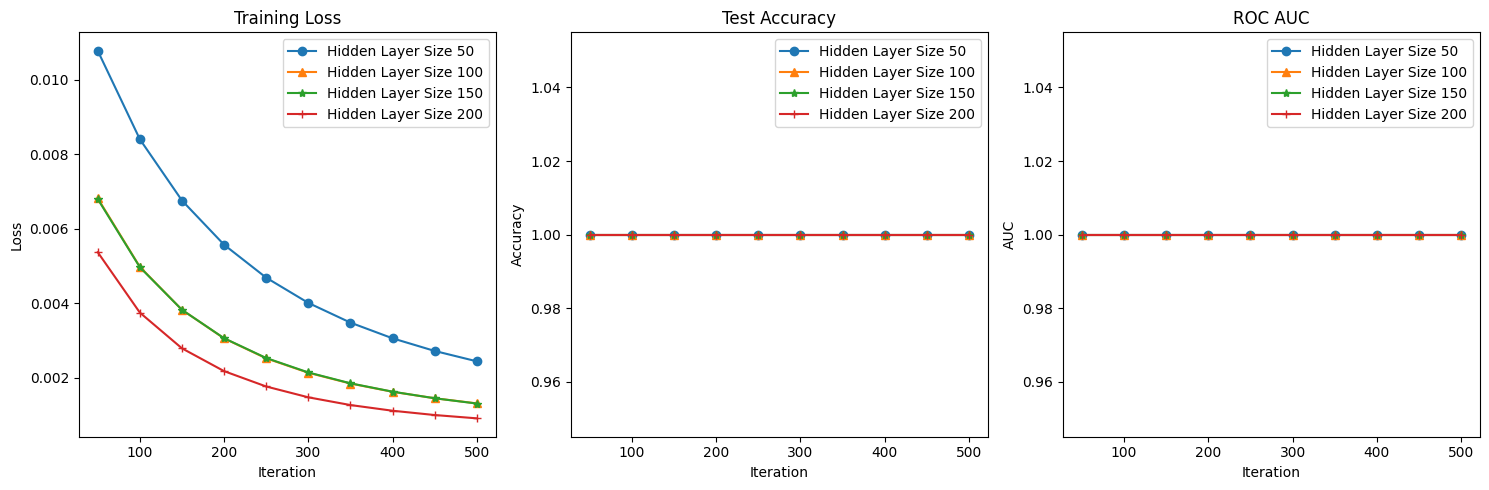

In [17]:
# Deep learning #

# ANN
hidden_layer_sizes = [50, 100, 150, 200]
loss_values = {size: [] for size in hidden_layer_sizes}
accuracy_values = {size: [] for size in hidden_layer_sizes}
roc_auc_values = {size: [] for size in hidden_layer_sizes}

confusion_matrices = {size: None for size in hidden_layer_sizes}
# Iterate over hidden layer sizes
for size in hidden_layer_sizes:
    # print(f"\nTraining with hidden layer size: {size}")
    
    # Initialize model with the current hidden layer size
    model = MLPClassifier(
        hidden_layer_sizes=(size,),
        max_iter=500,              # Set your desired maximum number of iterations
        random_state=42,
        alpha=0.001,               # L2 regularization strength
        solver='adam',             # Adam optimizer
        learning_rate_init=0.001,   # Learning rate
        tol=1e-4,                   # Tolerance for convergence
        early_stopping=False,       # No early stopping
    )
    model.fit(x_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    
    # Save the confusion matrix in the dictionary
    confusion_matrices[size] = confusion_matrix_result
    
    # Display confusion matrix for the current hidden layer size
    # print(f"\nConfusion Matrix for Hidden Layer Size {size}:\n")
    # print(confusion_matrix_result)
    # Training
    start_time = time.time()
    # Fit the model and store loss and accuracy at each iteration
    classes_initialized = False
    for iteration in range(1, model.max_iter + 1):
        if not classes_initialized:
            # On the first iteration, pass the classes to partial_fit
            model.partial_fit(x_train, y_train, classes=df['Output'].unique())
            classes_initialized = True
        else:
            # For subsequent iterations, use partial_fit without classes
            model.partial_fit(x_train, y_train)

        # Calculate loss on the training set
        loss_values[size].append(model.loss_)

        # Calculate accuracy on the test set
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_values[size].append(accuracy)

        # Calculate ROC curve and AUC for binary classification
        if len(set(y_train)) == 2:
            y_bin = label_binarize(y_test, classes=list(set(y_train)))
            fpr, tpr, _ = roc_curve(y_bin.ravel(), model.predict_proba(x_test)[:, 1])
            roc_auc = auc(fpr, tpr)
            roc_auc_values[size].append(roc_auc)
        
    training_time = time.time() - start_time
    
    # Testing
    start_time = time.time()
    _ = model.predict(x_test)
    test_time = time.time() - start_time
    
    # Print training and test times
    # print(f"Training Time: {training_time * 1e6:.2f} microseconds")
    # print(f"Test Time: {test_time * 1e6:.2f} microseconds")
    
    # Print number of train and test data
    # print(f"Number of Train Data: {len(x_train)}")
    # print(f"Number of Test Data: {len(x_test)}")
    
    # Print F1 score and accuracy
    f1 = f1_score(y_test, y_pred, average='weighted')
    # print(f"F1 Score: {f1:.4f}")
    
    accuracy = accuracy_score(y_test, y_pred)
    # print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(15, 5))

# Plot Loss Curve
plt.subplot(1, 3, 1)
markers = ['o', '^', '*', '+']
for i, (size, values) in enumerate(loss_values.items()):
    plt.plot(range(50, model.max_iter + 1, 50), values[49::50], marker=markers[i], label=f'Hidden Layer Size {size}')

plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot Accuracy Curve
plt.subplot(1, 3, 2)
for i, (size, values) in enumerate(accuracy_values.items()):
    plt.plot(range(50, model.max_iter + 1, 50), values[49::50], marker=markers[i], label=f'Hidden Layer Size {size}')


plt.title('Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot ROC Curve
plt.subplot(1, 3, 3)
if len(set(y_train)) == 2:
    for i, (size, values) in enumerate(roc_auc_values.items()):
        plt.plot(range(50, model.max_iter + 1, 50), values[49::50], marker=markers[i], label=f'Hidden Layer Size {size}')

    plt.title('ROC AUC')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [15]:
# ANN
ann = MLPClassifier(
     hidden_layer_sizes=(200,),
        max_iter=500,              # Set your desired maximum number of iterations
        random_state=42,
        alpha=0.001,              
        solver='adam',             
        learning_rate_init=0.001,   
        tol=1e-4,                   
        early_stopping=False, 
)
ann.fit(x_train, y_train)

# Traditional ML #

# Logistic regression
lr = LogisticRegression()
lr.fit(x_train, y_train)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# Decision tree
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

# SVM
svm = SVC(gamma='auto')
svm.fit(x_train, y_train)

# Naive bay
naive = GaussianNB()
naive.fit(x_train, y_train)


GaussianNB()

***Evaluation***

In [7]:
# Accuracy
ann_predict = ann.predict(x_test)
ann_acc = accuracy_score(y_true=y_test, y_pred=ann_predict)

# Logistic regression
lr_predict = lr.predict(x_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_predict)

# KNN
knn_predict = knn.predict(x_test)
knn_acc = accuracy_score(y_true=y_test, y_pred=knn_predict)

# Decision tree
tree_predict = tree.predict(x_test)
tree_acc = accuracy_score(y_true=y_test, y_pred=tree_predict)

# SVM
svm_predict = svm.predict(x_test)
svm_acc = accuracy_score(y_true=y_test, y_pred=svm_predict)

# Naive bay
naive_predict = naive.predict(x_test)
naive_acc = accuracy_score(y_true=y_test, y_pred=naive_predict)

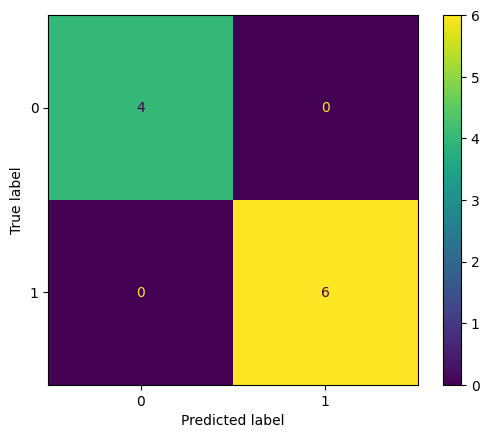

In [8]:
# confusion metrix
ann_cm = confusion_matrix(y_test, ann_predict, labels=ann.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=ann_cm,
                              display_labels=ann.classes_)
disp.plot()

***Test model***

In [99]:
testFile = pd.read_csv('../test_demo/B6_Mean0Std2_DEMO.csv', nrows=30)
testFile = testFile[testFile['FlowTemp_Tenths'] >= 35]

In [97]:
HeatDmd = [np.mean(testFile['HeatDmd'])]
TargetTemp_Tenths = [np.mean(testFile['TargetTemp_Tenths'])]
FlowTemp_Tenths = [np.mean(testFile['FlowTemp_Tenths'])]
CoolDmd = [np.mean(testFile['CoolDmd'])]
FTemp = [np.mean(testFile['FTemp'])]


dfDic = {'HeatDmd': HeatDmd, 'TargetTemp_Tenths': TargetTemp_Tenths, 'FlowTemp_Tenths': FlowTemp_Tenths, 
         'CoolDmd': CoolDmd, 'FTemp': FTemp}
dfTest = pd.DataFrame(dfDic)

dfTestSC = sc.transform(dfTest)
predictionTest = ann.predict(dfTestSC)
confidence_levels = ann.predict_proba(dfTestSC)
print(f'prediction: {predictionTest}, confidence: {confidence_levels.max(axis=1)}')


prediction: [0], confidence: [0.99707429]


***Test demo model***

In [16]:
demoDatas = {}
b = 1
g = 1

dataFile = []

for child in Path('../test_demo').iterdir():
    read = pd.read_csv(f'../test_demo/{child.name}', nrows=30)
    read = read[read['FlowTemp_Tenths'] >= 35]
    if pd.isna(np.mean(read['FTemp'])):
        pass
    else:
        if child.is_file() and child.name.startswith('B'):
            demoDatas[f'bg{b}'] = read
            dataFile.append({'file': child.name})
            b+=1
        else:
            demoDatas[f'gg{g}'] = read
            dataFile.append({'file': child.name})
            g+=1

HeatDmd = []
TargetTemp_Tenths = []
FlowTemp_Tenths = []
CoolDmd = []
FTemp = []
for i in demoDatas:
    FTemp.append(np.mean(demoDatas[i]['FTemp']))
    CoolDmd.append(np.mean(demoDatas[i]['CoolDmd']))
    FlowTemp_Tenths.append(np.mean(demoDatas[i]['FlowTemp_Tenths']))
    HeatDmd.append(np.mean(demoDatas[i]['HeatDmd']))
    TargetTemp_Tenths.append(np.mean(demoDatas[i]['TargetTemp_Tenths']))
dfDic = {'HeatDmd': HeatDmd, 'TargetTemp_Tenths': TargetTemp_Tenths, 'FlowTemp_Tenths': FlowTemp_Tenths, 
         'CoolDmd': CoolDmd, 'FTemp': FTemp}
dfTest = pd.DataFrame(dfDic)
dfTestSC = sc.transform(dfTest)
predictionTest = knn.predict(dfTestSC)
confidence_levels = knn.predict_proba(dfTestSC)
# print(f'prediction: {predictionTest}, confidence: {confidence_levels.max(axis=1)}')
for i in range(len(dataFile)):
    dataFile[i]['predict'] = predictionTest[i]
    dataFile[i]['confidence'] = confidence_levels.max(axis=1)[i]

In [21]:
dataFile

[{'file': 'B1_Mean0Std2_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B1_Mean1.5Std2_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B1_Mean10Std2_DEMO.csv', 'predict': 1, 'confidence': 0.8},
 {'file': 'B1_Mean12Std2.3_DEMO.csv', 'predict': 1, 'confidence': 0.8},
 {'file': 'B1_Mean1Std2.5_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B1_Mean3Std0.1_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B1_Mean5Std2_DEMO.csv', 'predict': 0, 'confidence': 0.6},
 {'file': 'B1_Mean6Std1.3_DEMO.csv', 'predict': 1, 'confidence': 0.6},
 {'file': 'B1_Mean6Std2.3_DEMO.csv', 'predict': 1, 'confidence': 0.6},
 {'file': 'B2DEMO0505.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B2_Mean0Std2_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B2_Mean1.5Std2_DEMO.csv', 'predict': 0, 'confidence': 1.0},
 {'file': 'B2_Mean10Std2_DEMO.csv', 'predict': 1, 'confidence': 0.8},
 {'file': 'B2_Mean12Std2.3_DEMO.csv', 'predict': 1, 'confidence': 0.8},
 {'file': 'B2_Mean1St

In [22]:
result = pd.DataFrame(dataFile)
resultTest = []
for i, v in enumerate(result['file']):
    if v.startswith('B') and result['predict'][i] == 0:
        resultTest.append('T')
    elif v.startswith('G') and result['predict'][i] == 1:
        resultTest.append('T')
    else:
        resultTest.append('F')
result['result']= resultTest

In [23]:
result

,file,predict,confidence,result
0,B1_Mean0Std2_DEMO.csv,0,1.0,T
1,B1_Mean1.5Std2_DEMO.csv,0,1.0,T
2,B1_Mean10Std2_DEMO.csv,1,0.8,F
3,B1_Mean12Std2.3_DEMO.csv,1,0.8,F
4,B1_Mean1Std2.5_DEMO.csv,0,1.0,T
...,...,...,...,...
90,G5_Mean1Std2.5_DEMO.csv,1,1.0,T
91,G5_Mean3Std0.1_DEMO.csv,1,1.0,T
92,G5_Mean5Std2_DEMO.csv,1,1.0,T
93,G5_Mean6Std1.3_DEMO.csv,1,1.0,T


In [94]:
result.to_csv('naive_test.csv', index=False)

***Export models***

In [8]:
# # export scaler model
# joblib.dump(sc, '../GUI/models/scaler_5_parameter.pkl')

# #export machine learning model
joblib.dump(knn, '../GUI/models/knn_model.pkl')

['../GUI/models/knn_model.pkl']

In [101]:
model = joblib.load('../GUI/models/best_5_parameter.pkl')
print(model.predict(dfTestSC))

[0]
